In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# ML library
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc


### Loading Data and Data Summary

In [44]:
algorithms = {
    'SVC-RBF': SVC(kernel='rbf', probability=True,random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    # 'Neural-Network-5': MLPClassifier(hidden_layer_sizes=[5], max_iter=20000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    # 'GradientBoosting': GradientBoostingClassifier(random_state=42),
    # 'KNeighbors': KNeighborsClassifier(n_neighbors=5),
}
file_path = '../outputs/features_data_labelled.csv'
np.random.seed(42)

##Program Starting Here!

In [46]:
def apply_sampling(X, y):
  # summarize class distribution
  print("Original :",Counter(y))
  rus = RandomUnderSampler(sampling_strategy={0: len(y[y != 0])}, random_state=42)
  X_rus, y_rus = rus.fit_resample(X, y)
  print("\nAfter Random Undersampling on class 0:", Counter(y_rus))
  return X_rus, y_rus

In [47]:
# Train and test model
def trainAndTestSplitData(X_features, y_features):
  # split into train/test sets with same class ratio
  trainX, testX, trainy, testy = model_selection.train_test_split(X_features, y_features, test_size=0.2,random_state=42, stratify=y_features)
  return trainX, testX, trainy, testy

In [48]:
def execute_model(trainX, testX, trainy, testy, model):
  # fit model
  model.fit(trainX, trainy)
  # predict on test set
  yhat = model.predict(testX)
  # evaluate predictions
  acc = metrics.accuracy_score(testy, yhat)
  prec = metrics.precision_score(testy, yhat, average='weighted')
  recall = metrics.recall_score(testy, yhat, average='weighted')
  f1_score = metrics.f1_score(testy, yhat, average='weighted')
  # Get classification report as dict for class-wise metrics
  classification_report = metrics.classification_report(testy, yhat, output_dict=True)
  return acc, prec, recall, f1_score, classification_report


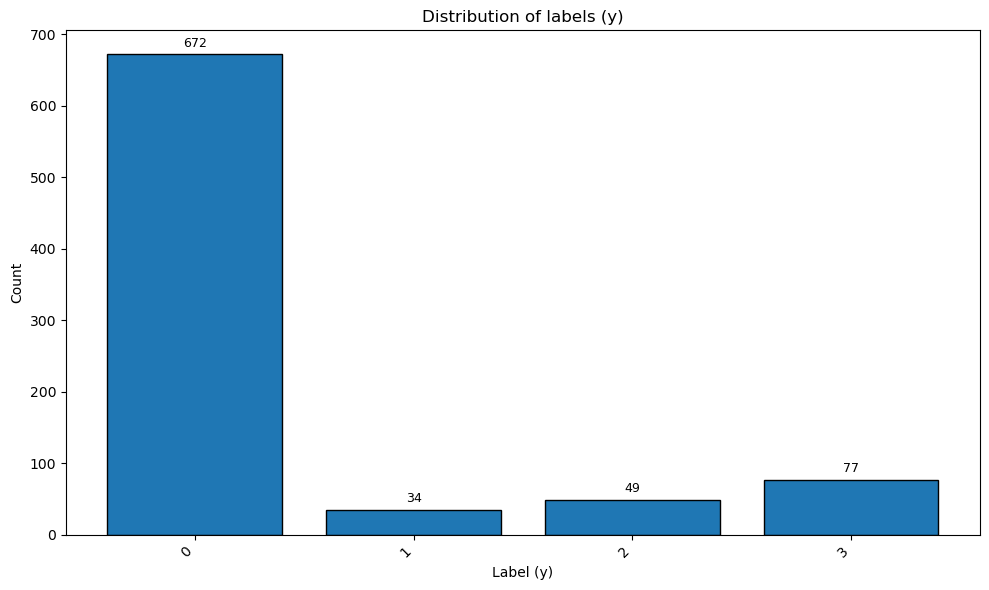

Original : Counter({0: 672, 3: 77, 2: 49, 1: 34})

After Random Undersampling on class 0: Counter({0: 160, 3: 77, 2: 49, 1: 34})
Original number of features: 3290
Number of features after PCA: 179


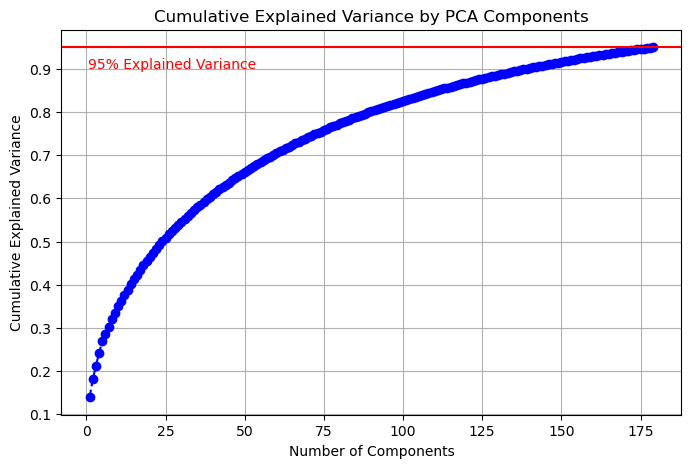

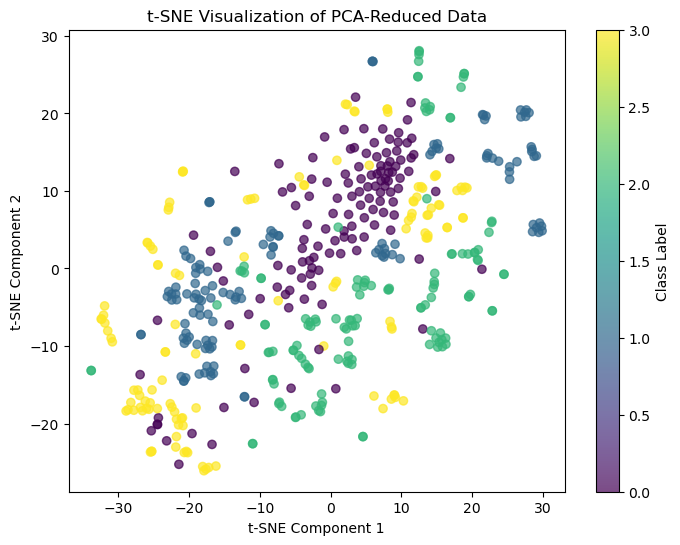

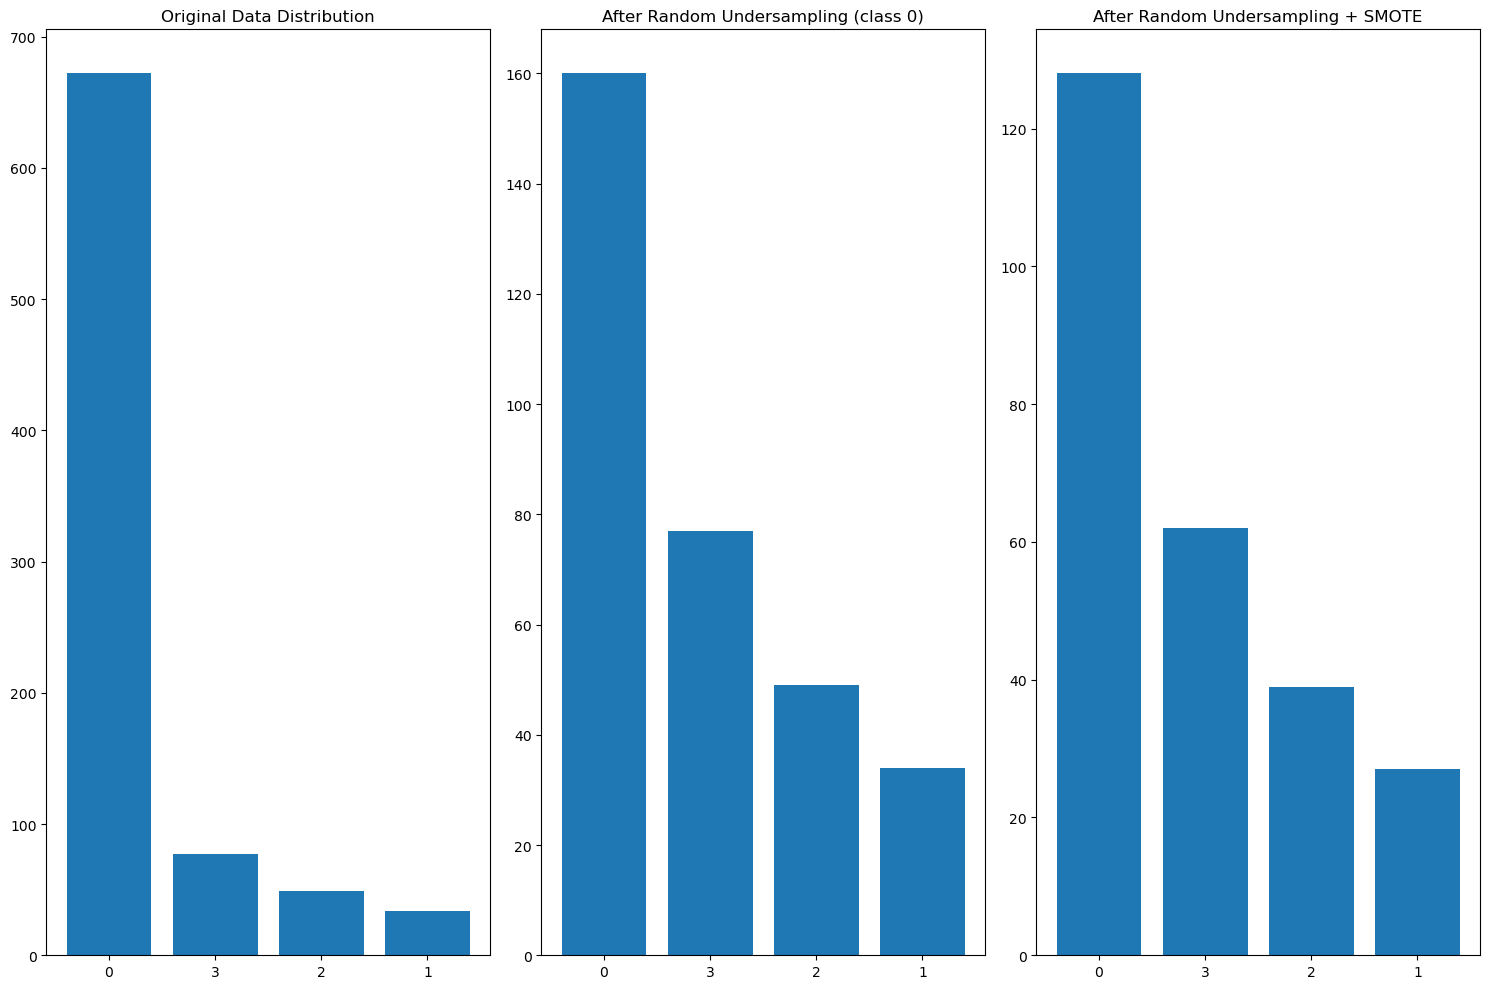

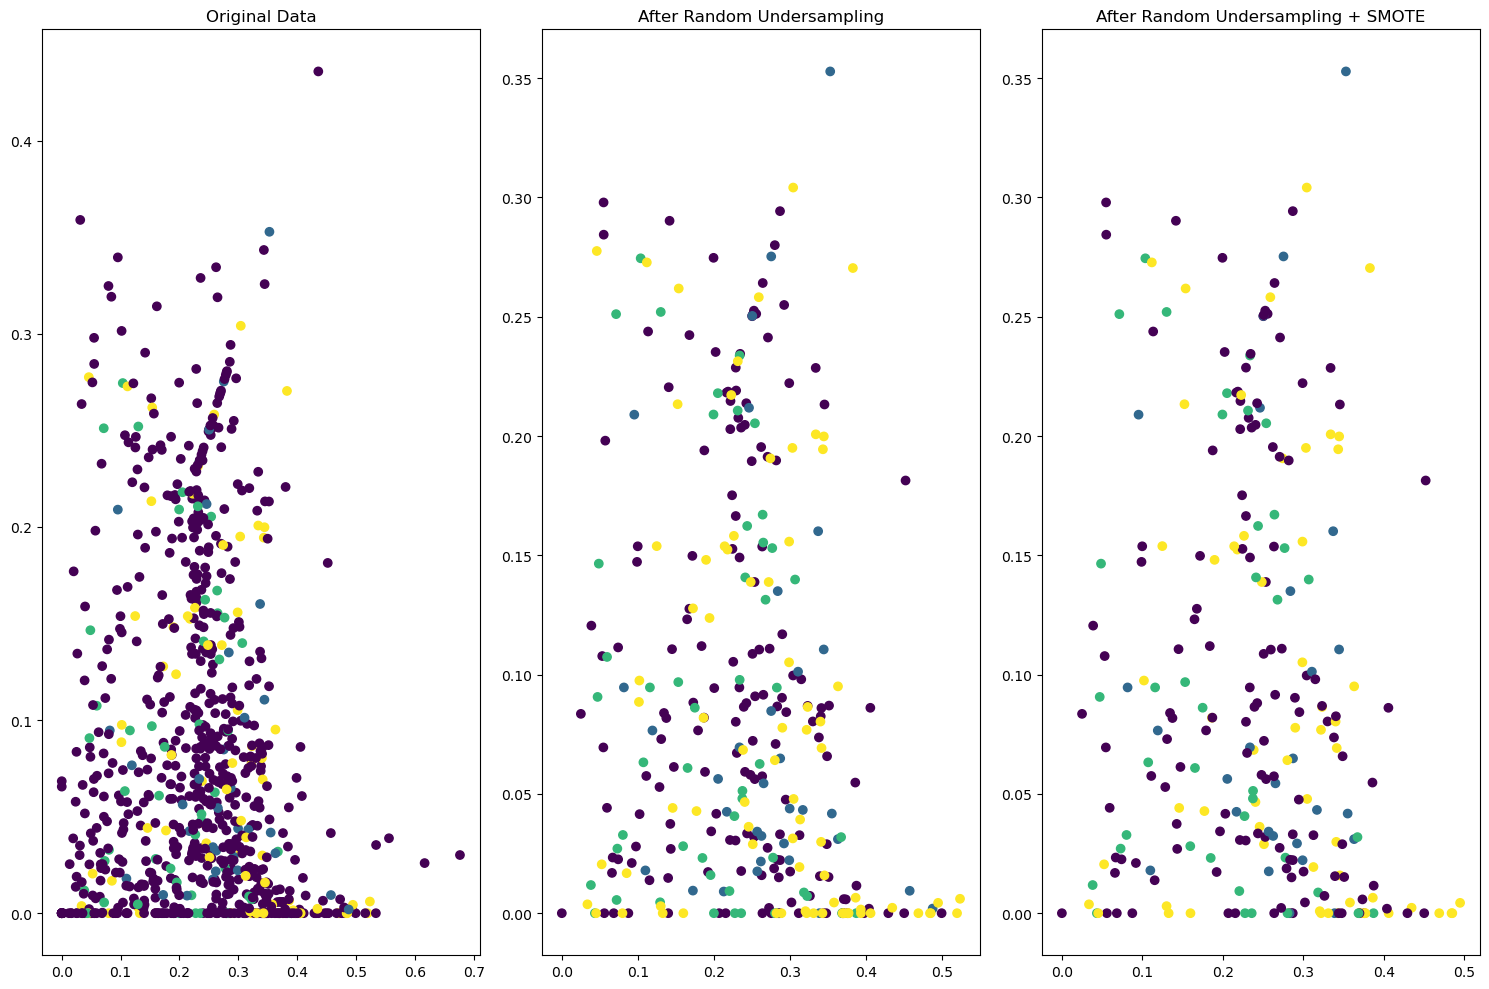

AttributeError: 'dict' object has no attribute 'accuracy_score'

In [60]:
apply_manual_undersampling = True
df = pd.read_csv(file_path)
df_clean = df.dropna()
X = df_clean.drop(['image', 'tile_i', 'tile_j', 'y'], axis=1)
y = df_clean['y']

counts = df_clean['y'].value_counts().sort_index()   # or .sort_values(ascending=False)
plt.figure(figsize=(10,6))
bars = plt.bar(counts.index.astype(str), counts.values, color='tab:blue', edgecolor='k')
plt.xlabel('Label (y)')
plt.ylabel('Count')
plt.title('Distribution of labels (y)')
plt.xticks(rotation=45, ha='right')

# annotate counts on top of each bar
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + max(counts.values)*0.01, f'{int(h)}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

if apply_manual_undersampling:
    ### Step 1: Apply Random Undersampling on class 0
    X_us, y_us = apply_sampling(X, y)
    ### Step 2: Train and Test Split on undersampled data
    trainX, testX, trainy, testy = trainAndTestSplitData(X_us, y_us)
else:
    ### Step 2: Train and Test Split on original data
    trainX, testX, trainy, testy = trainAndTestSplitData(X, y)
    
#### SMOTE - for multiclass, use 'not majority' or dict
oversample = SMOTE(random_state=42)
X_smote, y_smote = oversample.fit_resample(trainX, trainy)

#Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_smote)

#Perform PCA
pca = PCA(n_components=0.95)  # retain 95% of variance
X_pca = pca.fit_transform(X_scaled)
print(f'Original number of features: {X_smote.shape[1]}')
print(f'Number of features after PCA: {X_pca.shape[1]}')

#calculate cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.90, '95% Explained Variance', color = 'red', fontsize=10)
plt.show()

#Apply t-sne on pca reduced data
tsne = TSNE(n_components=2, random_state=42, init='pca',perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_smote, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE Visualization of PCA-Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### Plotting - Class distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].bar(y.value_counts().index.astype(str), y.value_counts().values)
ax[0].set_title("Original Data Distribution")
ax[1].bar(y_us.value_counts().index.astype(str), y_us.value_counts().values)
ax[1].set_title("After Random Undersampling (class 0)")
ax[2].bar(trainy.value_counts().index.astype(str), trainy.value_counts().values)
ax[2].set_title("After Random Undersampling + SMOTE")
plt.tight_layout()
plt.show()

### Plotting - Feature scatter plots
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].scatter(X.iloc[:, 0], X.iloc[:, 2], c = y)
ax[0].set_title("Original Data")
ax[1].scatter(X_us.iloc[:, 0], X_us.iloc[:, 2], c = y_us)
ax[1].set_title("After Random Undersampling")
ax[2].scatter(trainX.iloc[:, 0], trainX.iloc[:, 2], c = trainy)
ax[2].set_title("After Random Undersampling + SMOTE")
plt.tight_layout()
plt.show()

train_pca_X, test_pca_X, train_pca_y, test_pca_y = trainAndTestSplitData(X_pca, y_smote)
 
all_model_reports_list = []
for model_name, model in algorithms.items():
   
    acc_orig, prec_orig, recall_orig, f1_orig, report_orig = execute_model(trainX, testX, trainy, testy, model)
    acc_smote, prec_smote, recall_smote, f1_smote, report_smote = execute_model(train_pca_X, test_pca_X, train_pca_y, test_pca_y, model)
    df_result = pd.DataFrame({
        'Accuracy': [acc_orig, acc_smote ],
        'Precision': [prec_orig, prec_smote],
        'Recall': [recall_orig, recall_smote],
        'F1_score': [f1_orig, f1_smote]
    })

    df_result.index = ['Original Data', 'RUS + SMOTE']

    # Store classification reports for later use
    # Append the reports for the current model to our list
    all_model_reports_list.append({
        'Model': model_name,
        'Original Data': report_orig,
        'RUS + SMOTE': report_smote
    })
    
    from sklearn.metrics import roc_curve, auc

    y_proba = model.predict_proba(test_pca_X)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(test_pca_y))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_pca_y == i, y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    

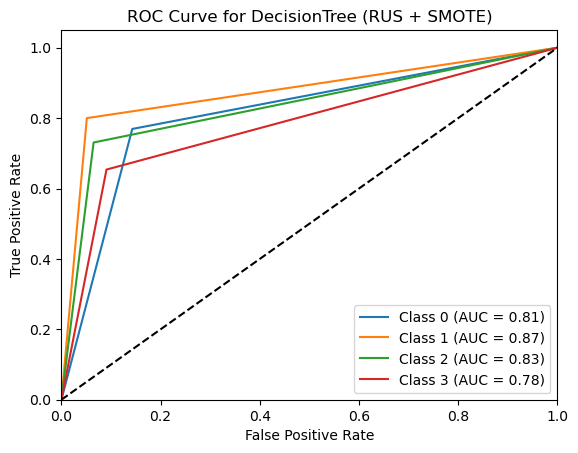

In [ ]:
#plot ROC curve and AUC for smote data


In [51]:

# Now, let's process the collected reports and display them in a table.
records = []
for report_item in all_model_reports_list:
    model_name = report_item['Model']
    for technique, report in report_item.items():
        if technique == 'Model':
            continue
        
        # Extract overall metrics
        records.append({
            'Model': model_name,
            'Technique': technique,
            'Class': 'accuracy',
            'F1-Score': report.get('accuracy', None),
            'Precision': None,
            'Recall': None,
            'Support': report.get('macro avg', {}).get('support', None)
        })
        
        # Extract class-specific and average metrics
        for class_label, metrics in report.items():
            if isinstance(metrics, dict): # This will capture classes and averages like 'macro avg'
                records.append({
                    'Model': model_name,
                    'Technique': technique,
                    'Class': class_label,
                    'F1-Score': metrics.get('f1-score'),
                    'Precision': metrics.get('precision'),
                    'Recall': metrics.get('recall'),
                    'Support': metrics.get('support')
                })

# Create a DataFrame and display it
df_reports = pd.DataFrame(records)

# Pivot for a more readable, wide-format table
report_table = df_reports.pivot_table(
    index=['Model', 'Technique'], 
    columns='Class', 
    values='F1-Score'
)

# Reorder columns for better readability
desired_order = [c for c in sorted(df_reports['Class'].unique(), key=lambda x: (str.isdigit(x), x)) if c in report_table.columns]
report_table = report_table[desired_order]


print("--- All Model Reports (F1-Scores) ---")
# Display the styled DataFrame
report_table.style.background_gradient(cmap='viridis', axis=1).format("{:.4f}").set_caption("F1-Scores by Model, Technique, and Class")

--- All Model Reports (F1-Scores) ---
